
Quantum Neural Network für die Regression einer Polynomfunktion bzw. beliebiger Funktionen
============================




Mit dem folgenden Code können mehrschichtige QNN erzeugt werden, die zur Regression beliebiger Funktionen in der Lage sind. In der Masterarbeit 'Implementierung neuronaler Netzstrukturen auf Quantencomputern am Beispiel einer Polynomregression' wird das Programm für die Regression in Kapitel 8.2 verwendet.
Es sei auf den Code von 'SimpleSinRegression' und 'ArbitraryFunctionRegression' verwiesen, der die Grundlagen des vorliegenden Programmes erläutert. Dieses Programm besitzt die gleichen Funktionalitäten wie 'ArbitraryFunctionRegression'. Allerdings wurde die Art und Weise der Berechnung der durchschnittlichen Messwerte verändert, um eine möglichst zeiteffiziente Berechnung der Schaltkreise auf Quantencomputern zu erzielen (siehe weiter unten).




### Import der Bibliotheken





In [1]:
# Math librarys
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Librarys for IBM devices
from qiskit import *
from qiskit import IBMQ, assemble, transpile
from qiskit.providers.ibmq import least_busy

# Librarys for working with qiskit
from qiskit import Aer, QuantumCircuit, QuantumRegister, execute
from qiskit.opflow import Z, I, StateFn
from qiskit.circuit import Parameter
from qiskit.opflow import CircuitSampler, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliExpectation
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from typing import Union
from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

# Load the IBM Account
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q')


<br/>

### Definition der Simulatoren und des Quantencomputers





In [2]:
## Hier werden die unterschiedlichen Simulatoren und Quantenprozessoren definiert, die weiter unten verwendet werden ##

# define quantum instances (statevector and sample based)
qi_sv = Aer.get_backend('aer_simulator_statevector')

# we set shots to 10 as this will determine the number of samples later on.
qi_qasm = Aer.get_backend('qasm_simulator')

# define smallest devices to find least busy backend
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits <= 5
                                   and not x.configuration().simulator)

# create a QNN instance with a real quantum processor 
backend = least_busy(small_devices)
print(backend)

qi_real = QuantumInstance(backend, shots=250)


<br/>

### Definition der wichtigen Funktionen





Wie bereits zu Beginn erwähnt, ist in diesem Programm die Berechnung der Durchschnittswerte der Schaltkreismessungen verändert. Die Funktion 'evaluate_expectation()' wurde durch die unten folgenden Funktionen ersetzt:
<br/>- 'pool_circuits()' ist eine Methode, um mehrere Schalkreise zusammenzufassen, welche auf einem Quantencomputer oder Quantensimulator berechnet werden sollen. Das soll die Berechnungszeit der Schaltkreise auf den realen Quantencomputern reduzieren. So müssen bspw. für die Berechnung des RMSE in Bezug auf die Trainingsdaten insgesamt 50 Schaltkreise berechnet werden (da 50 Trainingspunkten). Die Methode fasst alle diese Schaltkreise zusammen, sodass dann die Berechnung der Schaltkreise als ein Auftrag an IBM Quantum geschickt werden kann (bzw. an die Simulatoren, wobei hier keine wirkliche Rechenzeitersparnis vorhanden ist).
<br/>- 'calc_exp()' ist dann eine Methode zur Berechnng der Durchschnittswerte der Schaltkreismessungen. Zunächst wird die Liste der zusammengefassten Schaltkreise in 100er-Pakete unterteilt, da die Quantencomputer von IBM Quantum Aufträge mit maximal 100 Schaltkreisen akzeptieren. Anschließend werden diese gebündelten Aufträge zur Berechnung an den Quantencomputer oder an den Simulator geschickt. Auf Basis der Messergebnisse in Bezug auf die Standardbasis (0 oder 1) wird dann der Durchschnittswert berechnet. Verwendet man, wie in der Arbeit festgelegt, die Observable 'Z' für die Messung, wird dem Ergebnis '0' der Wert '1' und dem Messergebnis '1' der Wert '-1' zugeordnet und anschlißend der Durchschnitt berechnet.
<br/>- 'calc_exp_grad()' hat die identische Wirkung wie die Funktion oben, allerdings werden hier die Schaltkreise für die Bestimmung der Gradienten berechnet.
<br/>Die restlichen wichtigen Methoden des Programms wurden entsprechend angepasst, sodass sie mit den neuen, oben vorgestellten Funktionen arbeiten können.




In [3]:
# callback function that draws a live plot of the loss function and gets called by the training method
def callback_training(training_value):
    clear_output(wait=True)
    training_funct_vals.append(training_value)
    plt.title("Fehlerfunktion im Trainingsprozess")
    plt.xlabel("Iteration")
    plt.ylabel("Wert der Fehlerfunktion")
    plt.plot(range(len(training_funct_vals)), training_funct_vals)
    plt.show()

    
# Function to evaluate the expectation value of the quantum circuit. 
# The expectaton value represents the output of the QNN, with respect to
# a specific set of weights, an input x and an observable Z
def pool_circuits(weights,X):
    qc_list = []
        
    for x_ in X:
        weights_dict = weights[:]                                         
        weights_dict.append(x_)
    
        qc_exp = quantum_circuit.assign_parameters(weights_dict, inplace=False)
        qc_list.append(qc_exp)
        
    return qc_list

                
def calc_exp(qc_list_calc):
     
    exp_val_list = []
    statistics = [0.0,0.0]
    number_runs = math.ceil((len(qc_list_calc)/100))
    
    cut_qc_list = [qc_list_calc[i:i+100] for i in range(0, len(qc_list_calc), 100)] 
        
    for qc_list in cut_qc_list:
        job = execute(qc_list_calc, qnn_qi, shots = 250)
        results = job.result()
    
        for circuit in qc_list:
        
            try:
                statistics = [results.get_counts(circuit)['0'],results.get_counts(circuit)['1']]
            except KeyError as e:
                if e.args[0] == '0':
                    statistics[0] = 0
                elif e.args[0] == '1':
                    statistics[1] = 1
                else:
                    raise ValueError('Hier stimmt was nicht!')
      
            probabilities = [statistics[0]/250,statistics[1]/250] 
            expectation = probabilities[0]*1+probabilities[1]*(-1)
            exp_val_list.append(expectation)
    
    return exp_val_list

def calc_exp_grad(qc_list_calc):
     
    exp_val_list = []
    qc_list_grad = []
    statistics = [0.0,0.0]
    
    for w in qc_list_calc:
        for circuit in w:
            qc_list_grad.append(circuit)  
            
    number_runs = math.ceil((len(qc_list_grad)/100))
    
    cut_qc_list = [qc_list_grad[i:i+100] for i in range(0, len(qc_list_grad), 100)]
    
    for qc_list in cut_qc_list: 
        job = execute(qc_list, qnn_qi, shots = 250)
        results = job.result()
    
        for circuit in qc_list:
            try:
                statistics = [results.get_counts(circuit)['0'],results.get_counts(circuit)['1']]
            except KeyError as e:
                if e.args[0] == '0':
                    statistics[0] = 0
                elif e.args[0] == '1':
                    statistics[1] = 1
                else:
                    raise ValueError('Hier stimmt was nicht!')
      
            probabilities = [statistics[0]/250,statistics[1]/250] 
            expectation = probabilities[0]*1+probabilities[1]*(-1)
            exp_val_list.append(expectation)
    
    return exp_val_list
    
# Function to evaluate the finite difference gradient of a weight of the QNN
def evaluate_grad_finit_diff(weights):    
      
    grad_weights = []
    gradients_list = []
    predictions=[]
    grad_circuits=[]
    loss_list=[]
    loss = 0
    batch_list=[]
    y_batch_list=[]
        
    for w in range(len(weights)):
        # shift the QNN parameter (weight) of the given index by +- eps
        plus = weights[:]
        minus = weights[:]
        plus[w] += eps
        minus[w] -= eps
        grad_weights.append(plus)
        grad_weights.append(minus)
    
    # check, wether the batch size is smaller then the number of total learning examples
    if size_batch>num_samples:
        raise ValueError('Batch size is bigger then the number of learning examples!')
    
    for w in grad_weights:
        # form a batch of learning values, randomly picked out of X_learn 
        batch_indices = random.sample(range(0, X_learn.size), size_batch)
        batch = [X_learn[l] for l in batch_indices]
        y_batch = [y_learn[k] for k in batch_indices]
        batch_list.append(batch)
        y_batch_list.append(y_batch)
        grad_circuits.append(pool_circuits(w,batch))
    
    predictions = calc_exp_grad(grad_circuits)
    cut_predictions = [predictions[i:i+size_batch] for i in range(0, len(predictions), size_batch)]      
    
    for w,yb in zip(cut_predictions,y_batch_list):
        # calculate the loss with the quadratic difference function
        for t, p in zip(yb, w):
            loss = loss + (p - t) ** 2
        loss = 0.5*(loss / len(batch))
        loss_list.append(loss)
    
    iterations = list(range(0,len(loss_list),2))
    for l in iterations:
        gradient = (loss_list[l]-loss_list[l+1]) / (2* eps)
        gradients_list.append(gradient)
    
    # evaluate and return the finit difference gradient
    return gradients_list


# Calculate the RMSE of the QNN with respect to all the learning data 
def root_square_loss(weights):
    loss = 0
    predictions=[]
    # calculate the output of the QNN with the given weights for every input data in X_learn      
    circ_predictions = pool_circuits(weights,X_learn)
    predictions = calc_exp(circ_predictions)
    # sum up the squared difference between QNN predictions and the learning output y_learn    
    for t, p in zip(y_learn, predictions):
        loss = loss + (p - t) ** 2
    loss = loss / len(y_learn)
    return np.sqrt(loss)

def train_network(weights):
    # Prepare the lists and arrays for training
    weights_training = weights                                                # take the starting weights from the function argument 
    gradients = []                                                            # list for gradients
    delta = np.full(len(weights), 0.0)                                        # list for the updates of the weights
    X_learning_steps = np.full([learning_steps], range(learning_steps))       # list with the leaning steps
    RMSE_training = np.full([learning_steps], 0.0)                            # list for the RMSE after every training step

    # Train the weights
    for j in range(learning_steps):
        gradients = evaluate_grad_finit_diff(weights_training)
        for k in range(len(weights_training)):
            delta[k] = -gradients[k]*learning_rate
            weights_training[k] += delta[k]
        RMSE_training[j] = root_square_loss(weights_training)                 # calculate the RMSE after every learning step
        callback_training(RMSE_training[j])                                   # call the function to plot the RMSE
          
    return weights_training

# Function for adding a S-Gate to the quantum circuit of the QNN
def S(x, quantum_circuit):
    "Add a data encoding circuit block to the circuit."
    quantum_circuit.ry(scaling*x, 0)

# Function for adding an U-Gate to the quantum circuit of the QNN
def W(theta, quantum_circuit):
    """Trainable circuit block."""
    quantum_circuit.u(theta[0], theta[1], theta[2], 0)

# Function for creating the quantum circuit that represents the QNN
def serial_quantum_model(r):
    
    qc = QuantumCircuit(1)
    
    # first, delete all gates on quantum circuit instance
    if(qc.num_qubits!=0):
        while qc.depth() > 0:
            qc.data.pop(-1)
    
    # create the parameter list for the circuit
    param_input = Parameter('x')
    params_weight = [ [ None for y in range(3) ] for x in range( r+1 ) ]
    
    for i in range(r+1):
        string_theta1 = 'theta1.{}'.format(i)
        string_theta2 = 'theta2.{}'.format(i)
        string_theta3 = 'theta3.{}'.format(i)
        params_weight[i][0] = Parameter(string_theta1)
        params_weight[i][1] = Parameter(string_theta2)
        params_weight[i][2] = Parameter(string_theta3)
    
    # add the S- and U-gates to the quantum circuit
    for l in range(r):
        W(params_weight[l], qc)
        S(param_input, qc)
        
    # L+1'th unitary
    W(params_weight[r], qc)
    qc.measure_all()
    
    return qc

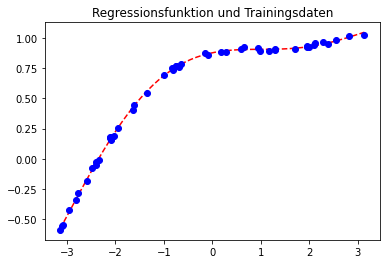

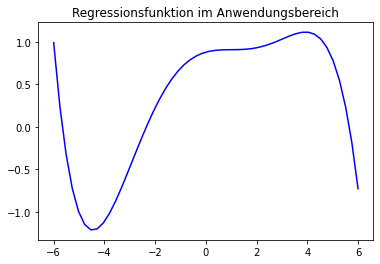

In [4]:
## Anzahl Lern- und Testdatenpunkte ##
num_samples = 50

## LERNBEREICH ## 
x_learn_min = -np.pi
x_learn_max = np.pi

## ANWENDUNGSBEREICH ##
x_apply_min = -6
x_apply_max = 6

X_ = np.linspace(x_learn_min, x_learn_max, num=50)
X_2 = np.linspace(x_apply_min, x_apply_max, num=50)


#Sinus
#scaling = 1
#f = lambda x: np.sin(x)

#Glockenkurve
#scaling = 1
#f = lambda x: (2/np.exp(0.4*x**2))-1

#Gerade
#scaling = 0.5
#f = lambda x: x/np.pi

#Polynom
scaling = 0.5
f = lambda x: ((-0.072*x**5+0.133*x**4+2.102*x**3-6.404*x**2+6.49*x-1.708)*(1/78))+0.9

#create training and test data
X_learn = np.random.uniform(x_learn_min, x_learn_max, num_samples)
X_apply = np.random.uniform(x_apply_min, x_apply_max, num_samples)
y_learn = np.array([f(x_)+(random.uniform(-0.02,0.02)) for x_ in X_learn])
y_apply = f(X_apply)


# plot training data
plt.title("Regressionsfunktion und Trainingsdaten")
plt.plot(X_, f(X_), "r--")
plt.plot(X_learn, y_learn, "bo")
plt.show()

plt.title("Regressionsfunktion im Anwendungsbereich")
plt.plot(X_2,f(X_2),"b")
plt.show()

C:\Users\User\anaconda3\envs\ibmqiskit\lib\site-packages\sympy\core\expr.py:3951: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  deprecated_since_version="1.9").warn()


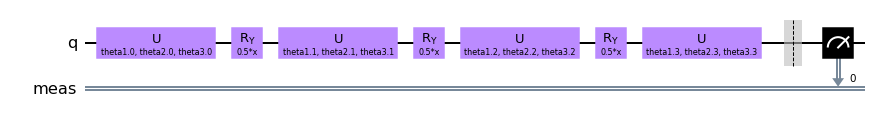

In [5]:
# Create similar circuit in parallel
r = 3 # number of times the encoding gets repeated (here equal to the number of layers)

quantum_circuit = serial_quantum_model(r)

#draw quantum circuit
quantum_circuit.draw('mpl')

RMSE_notraining:  0.6202542889662417


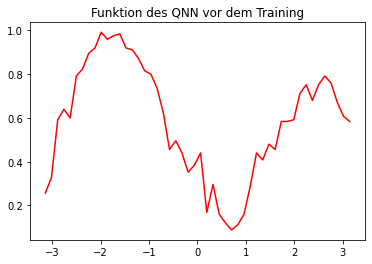

In [7]:
## parameters of training ##
starting_weights = [np.random.uniform(0,2*np.pi) for y in range(len(quantum_circuit.parameters)-1)]

# choose, which Quantum Instance will be used to calculate expectation values:
#qi_sv   = state vector based evaluation (no noise)
#qi_qasm = simulator based evaluation (noise simulation)
#qi_real = execution on real quantum processor
qnn_qi = qi_qasm


#calculate RMSE
RMSE_notraining = root_square_loss(starting_weights)
print('RMSE_notraining: ', RMSE_notraining)

# plot network-function without training
y_notraining = calc_exp(pool_circuits(starting_weights,X_))
plt.plot(X_, y_notraining, "r-")
plt.title("Funktion des QNN vor dem Training")
plt.show()

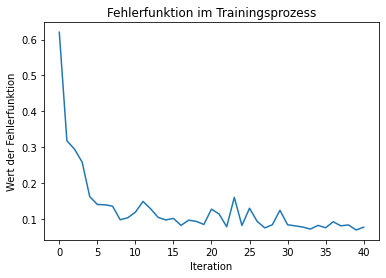

RMSE simulation (after training):  0.06776810813350242


In [8]:
## Train the Network ##
eps = 0.15                             # parameter for the Gradients
learning_rate = 0.8                    # learning rate for the weights of the network
learning_steps = 40                    # number of learning steps durign training
size_batch = 4                         # number of learning examples to compute the loss function

# Prepare the callback function to plot the training progress
training_funct_vals = []

# Plot the RMSE before training into the diagram
callback_training(RMSE_notraining)

# Train the network
opt_weights = train_network(starting_weights)

    
# Calculate final RMSE with apply action
RMSE_simulation = root_square_loss(opt_weights)
print('RMSE simulation (after training): ', RMSE_simulation) 


Final loss:  0.07047841225051363


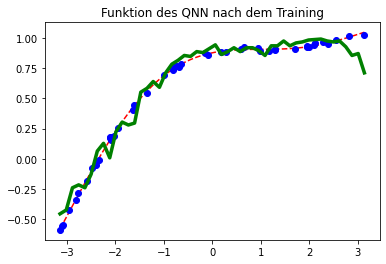

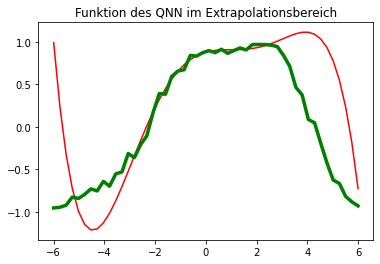

In [9]:
print('Final loss: ', root_square_loss(opt_weights))

# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X_learn, y_learn, "bo")

# plot fitted line
#Netzwerkfunktion
y_NN = calc_exp(pool_circuits(opt_weights,X_))
plt.plot(X_, y_NN, "g-",  linewidth=3.5)
plt.title("Funktion des QNN nach dem Training")
plt.show()

y_NN_extra = calc_exp(pool_circuits(opt_weights,X_2))
plot2 = plt.plot(X_2, f(X_2), "r-")
plot2 = plt.plot(X_2, y_NN_extra, "g-",  linewidth=3.5)
plt.title("Funktion des QNN im Extrapolationsbereich")
plt.show(plot2)